In [ ]:
 !pip install yfinance pandas numpy scipy

Descargando datos...
Descargando XLK...
Descargando XLY...
Descargando XLI...
Descargando XLP...
Descargando XLU...
Descargando XLV...
Descargando ^VIX...
Descargando ^VIX3M...
Datos descargados. Shape: (990, 9)
Calculando oscilador...
Oscilador calculado. Shape: (990, 7)
Creando gráfico...


C:\Users\filip\AppData\Local\Temp\ipykernel_18208\1056620877.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


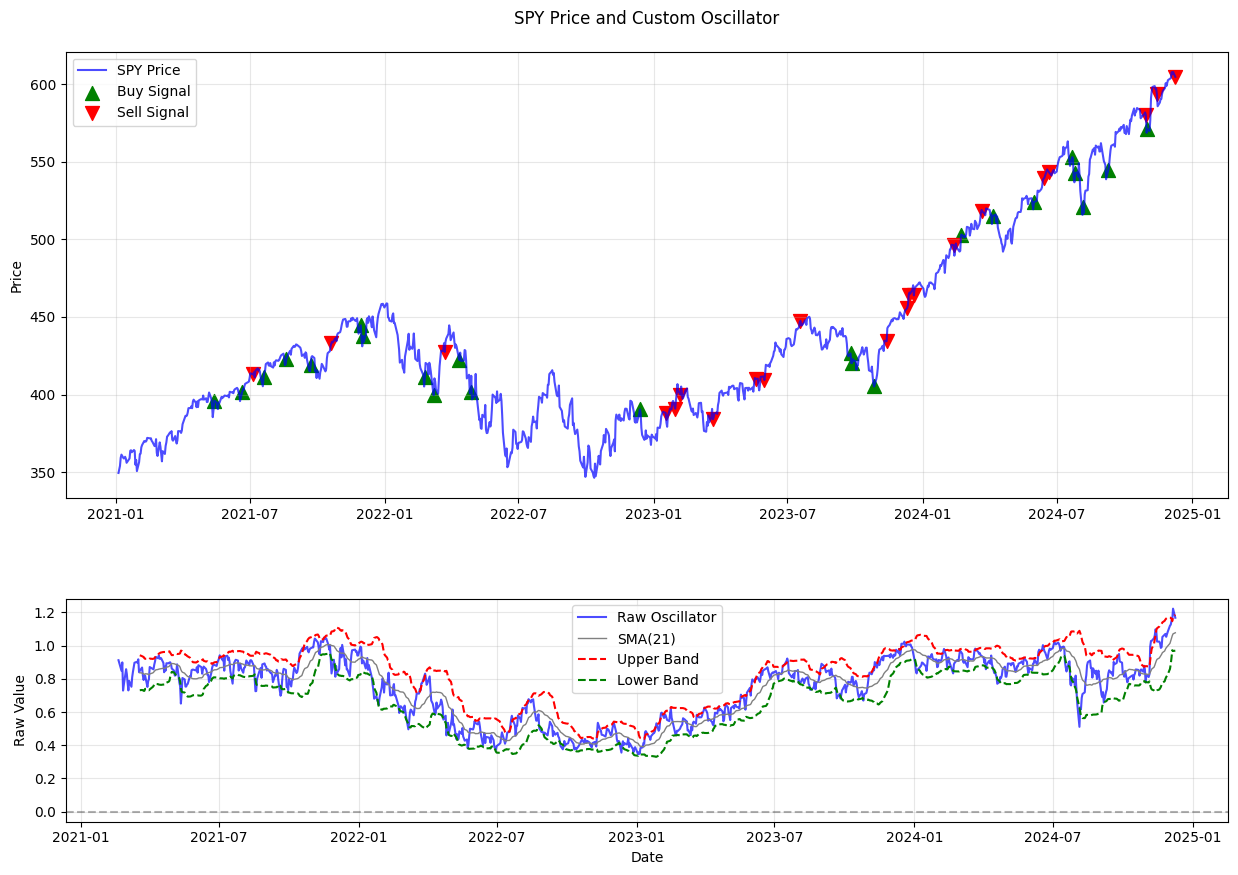


Estadísticas de señales:
Número de señales de compra: 23
Número de señales de venta: 21


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def fetch_data(start_date='2021-01-01', end_date='2024-12-10'):
    print("Descargando datos...")
    spy = yf.download('SPY', start=start_date, end=end_date, progress=False)
    data = pd.DataFrame(index=spy.index)
    data['SPY'] = spy['Adj Close']

    other_tickers = ['XLK', 'XLY', 'XLI', 'XLP', 'XLU', 'XLV', '^VIX', '^VIX3M']

    for ticker in other_tickers:
        print(f"Descargando {ticker}...")
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        data[ticker] = df['Adj Close']

    data = data.dropna()
    return data

def calculate_oscillator(df):
    try:
        # Calculate EMAs for SPY
        spy_ema8 = df['SPY'].ewm(span=8, adjust=False).mean()
        spy_ema24 = df['SPY'].ewm(span=24, adjust=False).mean()

        # Calculate momentum
        momentum = df['SPY'].pct_change(32)

        # Calculate Cyclical/Defensive ratio
        cyclical = df[['XLK', 'XLY', 'XLI']].mean(axis=1)
        defensive = df[['XLP', 'XLU', 'XLV']].mean(axis=1)
        cycl_def_ratio = cyclical / defensive

        # Calculate VIX ratio
        vix_ratio = df['^VIX'] / df['^VIX3M']

        # Calculate the oscillator
        oscillator = (
            ((spy_ema8 - spy_ema24) / spy_ema24) *
            momentum + (cycl_def_ratio - vix_ratio)
        )

        # Calcular Bandas de Bollinger
        window = 21  # Periodo estándar para BB
        std_dev = 1.75  # Número de desviaciones estándar

        sma = oscillator.rolling(window=window).mean()
        std = oscillator.rolling(window=window).std()
        upper_band = sma + (std_dev * std)
        lower_band = sma - (std_dev * std)

        # Detectar señales
        previous_osc = oscillator.shift(1)

        # Señales cuando el oscilador cruza las bandas
        buy_signals = (oscillator > lower_band) & (previous_osc <= lower_band)
        sell_signals = (oscillator < upper_band) & (previous_osc >= upper_band)

        results = pd.DataFrame({
            'price': df['SPY'],
            'oscillator': oscillator,
            'sma': sma,
            'upper_band': upper_band,
            'lower_band': lower_band,
            'buy_signal': buy_signals,
            'sell_signal': sell_signals
        })

        return results

    except Exception as e:
        print(f"Error en calculate_oscillator: {str(e)}")
        raise

def plot_oscillator(df):
    try:
        plt.style.use('default')
        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.3)

        # Subplot 1: Precio SPY con señales
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(df.index, df['price'], label='SPY Price', color='blue', alpha=0.7)

        buy_dates = df[df['buy_signal']].index
        sell_dates = df[df['sell_signal']].index

        ax1.scatter(buy_dates, df.loc[buy_dates, 'price'],
                   marker='^', color='green', s=100, label='Buy Signal')
        ax1.scatter(sell_dates, df.loc[sell_dates, 'price'],
                   marker='v', color='red', s=100, label='Sell Signal')

        ax1.set_title('SPY Price and Custom Oscillator', pad=20)
        ax1.set_xlabel('')
        ax1.set_ylabel('Price')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Subplot 2: Oscilador con Bandas de Bollinger
        ax2 = fig.add_subplot(gs[1])
        ax2.plot(df.index, df['oscillator'], label='Raw Oscillator', color='blue', alpha=0.7)
        ax2.plot(df.index, df['sma'], label='SMA(21)', color='gray', linewidth=1)
        ax2.plot(df.index, df['upper_band'], label='Upper Band', color='red', linestyle='--')
        ax2.plot(df.index, df['lower_band'], label='Lower Band', color='green', linestyle='--')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Raw Value')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    except Exception as e:
        print(f"Error en plot_oscillator: {str(e)}")
        raise

def main():
    try:
        # Fetch data
        market_data = fetch_data()
        print(f"Datos descargados. Shape: {market_data.shape}")

        # Calculate oscillator
        print("Calculando oscilador...")
        results = calculate_oscillator(market_data)
        print(f"Oscilador calculado. Shape: {results.shape}")

        # Create and show plot
        print("Creando gráfico...")
        fig = plot_oscillator(results)
        plt.show()

        # Imprimir estadísticas de señales
        n_buy = results['buy_signal'].sum()
        n_sell = results['sell_signal'].sum()
        print(f"\nEstadísticas de señales:")
        print(f"Número de señales de compra: {n_buy}")
        print(f"Número de señales de venta: {n_sell}")

        return results

    except Exception as e:
        print(f"Error en main: {str(e)}")
        raise

if __name__ == "__main__":
    df = main()